# Installations

In [ ]:
!pip install evaluate transformers[sentencepiece]
!pip install accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 54.6 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which i

# Hugging face login

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

# GPU Setup

In [ ]:
import torch
import random
import numpy as np

# Check if a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU")

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

GPU is available


# Model Setup

We load the pre-trained uncased DistilBERT model, which is a suitable choice due to its faster training time compared to BERT models. This is because DistilBERT has significantly fewer parameters. Given that our focus is on comparing performance improvements with different masking strategies, using a model that can be trained more quickly is advantageous.

In [ ]:
from transformers import AutoModelForMaskedLM

model_checkpoint = "distilbert-base-uncased"

# Tokenizer Setup

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

# Dataset Setup

We load the IMDB dataset. This is a suitable choice as it is a widely recognized benchmark for a wide range of NLP tasks. The dataset contains 50,000 highly polar movie reviews, evenly split between positive and negative sentiments, providing a balanced and comprehensive foundation for training and evaluating our model. Its popularity in the research community ensures that our results can be compared against numerous established baselines, allowing for robust performance evaluation. Additionally, the IMDB dataset's large size and real-world relevance make it an ideal candidate for testing the efficacy of different masking strategies and the capabilities of our chosen model, DistilBERT.

In [ ]:
!git clone https://github.com/gavicohen0314/NLP-Final-Project.git
!mv NLP-Final-Project/data/downsampled_dataset.zip downsampled_dataset.zip
!mv NLP-Final-Project/masking .
!mv NLP-Final-Project/CustomTrainer.py CustomTrainer.py
!rm -r NLP-Final-Project

Cloning into 'NLP-Final-Project'...
remote: Enumerating objects: 307, done.
remote: Counting objects: 100% (295/295), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 307 (delta 171), reused 183 (delta 94), pack-reused 12 (from 1)
Receiving objects: 100% (307/307), 28.78 MiB | 14.58 MiB/s, done.
Resolving deltas: 100% (173/173), done.


In [ ]:
from datasets import load_from_disk
import zipfile

# Extract the zip file
with zipfile.ZipFile("downsampled_dataset.zip", "r") as zip_ref:
    zip_ref.extractall("downsampled_dataset")

# Load the dataset from the unzipped directory
downsampled_dataset = load_from_disk("downsampled_dataset")


# Training

In [ ]:
import sys
from transformers import default_data_collator
sys.path.append('/content/masking')

In [ ]:
from random_masking import random_collator
from whole_word_random_masking import whole_word_random_collator
from min_loss_masking import min_loss_data_collator
from max_loss_masking import max_loss_data_collator
from pseudo_max_perplexity_masking import psudo_max_loss_data_collator
from pseudo_min_perplexity_masking import psudo_min_loss_data_collator
from pseudo_min_perplexity_masking import psudo_min_loss_data_collator
from pseudo_min_perplexity_masking_ww import psudo_min_loss_data_collator_ww
from pseudo_max_perplexity_masking_ww import psudo_max_loss_data_collator_ww

from CustomTrainer import CustomTrainer

In [ ]:
from transformers import DataCollatorForLanguageModeling
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=True, mlm_probability=0.15)

downsampled_dataset['test'] = downsampled_dataset['test'].remove_columns(["word_ids"])
def insert_mask(batch):
  features = [dict(zip(batch, t)) for t in zip(*batch.values())]
  masked_inputs = data_collator(features)
  return {"masked_" + k: v.cpu().numpy() for k, v in masked_inputs.items()}

eval_dataset = downsampled_dataset["test"].map(
    insert_mask,
    batched=True,
    remove_columns=downsampled_dataset["test"].column_names,
)

eval_dataset = eval_dataset.rename_columns(
  {
      "masked_input_ids": "input_ids",
      "masked_attention_mask": "attention_mask",
      "masked_labels": "labels",
  }
)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
losses_train = {}
losses_eval = {}
accuracies_eval = {}
precisions_eval = {}
recalls_eval = {}
f1_scores_eval = {}

collators = [random_collator, whole_word_random_collator, psudo_max_loss_data_collator, psudo_min_loss_data_collator, max_loss_data_collator, min_loss_data_collator, psudo_min_loss_data_collator_ww, psudo_max_loss_data_collator_ww]
names = [ "random", "random-whole-word", "pseudo-max","pseudo-min", "max-loss", "min-loss", "pseudo-min-ww", "pseudo-max-ww"]
for collator, name in zip(collators, names):
    model = AutoModelForMaskedLM.from_pretrained(model_checkpoint).to(device)
    data_collator = collator(model, tokenizer, device)
    trainer = CustomTrainer(model, tokenizer, device, downsampled_dataset['train'], eval_dataset, data_collator)

    trainer.train()
    model.push_to_hub(name)

    # Store losses and metrics
    losses_train[name] = trainer.train_losses
    losses_eval[name] = trainer.eval_losses
    accuracies_eval[name] = trainer.accuracies
    precisions_eval[name] = trainer.precisions
    recalls_eval[name] = trainer.recalls
    f1_scores_eval[name] = trainer.f1_scores
    del model
    del trainer
    del data_collator
    torch.cuda.empty_cache()

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

  0%|          | 0/785 [00:00<?, ?it/s]

>>> Pre-Training: Perplexity: 19.9281, Accuracy: 0.4026, Precision: 0.1917, Recall: 0.2217, F1: 0.1859
>>> 0: Perplexity: 10.8437, Accuracy: 0.5073, Precision: 0.2774, Recall: 0.2393, F1: 0.2398
>>> 1: Perplexity: 10.4352, Accuracy: 0.5144, Precision: 0.2826, Recall: 0.2429, F1: 0.2441
>>> 2: Perplexity: 10.1907, Accuracy: 0.5193, Precision: 0.2847, Recall: 0.2449, F1: 0.2462
>>> 3: Perplexity: 10.0548, Accuracy: 0.5222, Precision: 0.2854, Recall: 0.2477, F1: 0.2485
>>> 4: Perplexity: 9.9916, Accuracy: 0.5235, Precision: 0.2869, Recall: 0.2493, F1: 0.2501


README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

  0%|          | 0/785 [00:00<?, ?it/s]

>>> Pre-Training: Perplexity: 19.9281, Accuracy: 0.4026, Precision: 0.1917, Recall: 0.2217, F1: 0.1859
>>> 0: Perplexity: 11.2763, Accuracy: 0.5012, Precision: 0.2712, Recall: 0.2287, F1: 0.2305
>>> 1: Perplexity: 11.0585, Accuracy: 0.5070, Precision: 0.2685, Recall: 0.2313, F1: 0.2309
>>> 2: Perplexity: 10.8766, Accuracy: 0.5103, Precision: 0.2701, Recall: 0.2316, F1: 0.2319
>>> 3: Perplexity: 10.6841, Accuracy: 0.5130, Precision: 0.2720, Recall: 0.2331, F1: 0.2338
>>> 4: Perplexity: 10.6617, Accuracy: 0.5135, Precision: 0.2708, Recall: 0.2336, F1: 0.2335


README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

  0%|          | 0/785 [00:00<?, ?it/s]

>>> Pre-Training: Perplexity: 19.9281, Accuracy: 0.4026, Precision: 0.1917, Recall: 0.2217, F1: 0.1859
>>> 0: Perplexity: 10.7678, Accuracy: 0.5086, Precision: 0.2770, Recall: 0.2366, F1: 0.2380
>>> 1: Perplexity: 10.3593, Accuracy: 0.5160, Precision: 0.2837, Recall: 0.2424, F1: 0.2444
>>> 2: Perplexity: 10.1445, Accuracy: 0.5202, Precision: 0.2833, Recall: 0.2453, F1: 0.2459
>>> 3: Perplexity: 9.9832, Accuracy: 0.5229, Precision: 0.2853, Recall: 0.2483, F1: 0.2489
>>> 4: Perplexity: 9.9299, Accuracy: 0.5248, Precision: 0.2868, Recall: 0.2483, F1: 0.2495


README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

  0%|          | 0/785 [00:00<?, ?it/s]

>>> Pre-Training: Perplexity: 19.9281, Accuracy: 0.4026, Precision: 0.1917, Recall: 0.2217, F1: 0.1859
>>> 0: Perplexity: 10.9413, Accuracy: 0.5063, Precision: 0.2781, Recall: 0.2376, F1: 0.2390
>>> 1: Perplexity: 10.5360, Accuracy: 0.5130, Precision: 0.2793, Recall: 0.2396, F1: 0.2414
>>> 2: Perplexity: 10.3653, Accuracy: 0.5172, Precision: 0.2789, Recall: 0.2444, F1: 0.2437
>>> 3: Perplexity: 10.1739, Accuracy: 0.5195, Precision: 0.2826, Recall: 0.2441, F1: 0.2456
>>> 4: Perplexity: 10.1100, Accuracy: 0.5209, Precision: 0.2825, Recall: 0.2448, F1: 0.2459


README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

  0%|          | 0/785 [00:00<?, ?it/s]

>>> Pre-Training: Perplexity: 19.9281, Accuracy: 0.4026, Precision: 0.1917, Recall: 0.2217, F1: 0.1859
>>> 0: Perplexity: 13.1633, Accuracy: 0.4768, Precision: 0.2536, Recall: 0.2399, F1: 0.2294
>>> 1: Perplexity: 13.6105, Accuracy: 0.4669, Precision: 0.2498, Recall: 0.2426, F1: 0.2282
>>> 2: Perplexity: 13.7355, Accuracy: 0.4635, Precision: 0.2456, Recall: 0.2436, F1: 0.2272
>>> 3: Perplexity: 13.7459, Accuracy: 0.4614, Precision: 0.2472, Recall: 0.2440, F1: 0.2279
>>> 4: Perplexity: 13.9140, Accuracy: 0.4588, Precision: 0.2459, Recall: 0.2446, F1: 0.2274


README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

  0%|          | 0/785 [00:00<?, ?it/s]

>>> Pre-Training: Perplexity: 19.9281, Accuracy: 0.4026, Precision: 0.1917, Recall: 0.2217, F1: 0.1859
>>> 0: Perplexity: 18.9091, Accuracy: 0.4494, Precision: 0.2697, Recall: 0.1956, F1: 0.2104
>>> 1: Perplexity: 20.5309, Accuracy: 0.4508, Precision: 0.2675, Recall: 0.1971, F1: 0.2106
>>> 2: Perplexity: 20.2354, Accuracy: 0.4531, Precision: 0.2669, Recall: 0.2025, F1: 0.2140
>>> 3: Perplexity: 20.0031, Accuracy: 0.4557, Precision: 0.2681, Recall: 0.2044, F1: 0.2155
>>> 4: Perplexity: 20.5023, Accuracy: 0.4561, Precision: 0.2672, Recall: 0.2047, F1: 0.2153


README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
import json
from google.colab import files

# Combine all dictionaries into one for saving
results = {
    "losses_train": losses_train,
    "losses_eval": losses_eval,
    "accuracies_eval": accuracies_eval,
    "precisions_eval": precisions_eval,
    "recalls_eval": recalls_eval,
    "f1_scores_eval": f1_scores_eval
}

# Save the combined dictionary to a JSON file
results_file_path = "models_metrics.json"
with open(results_file_path, 'w') as f:
    json.dump(results, f, indent=4)

# Download the file
files.download(results_file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

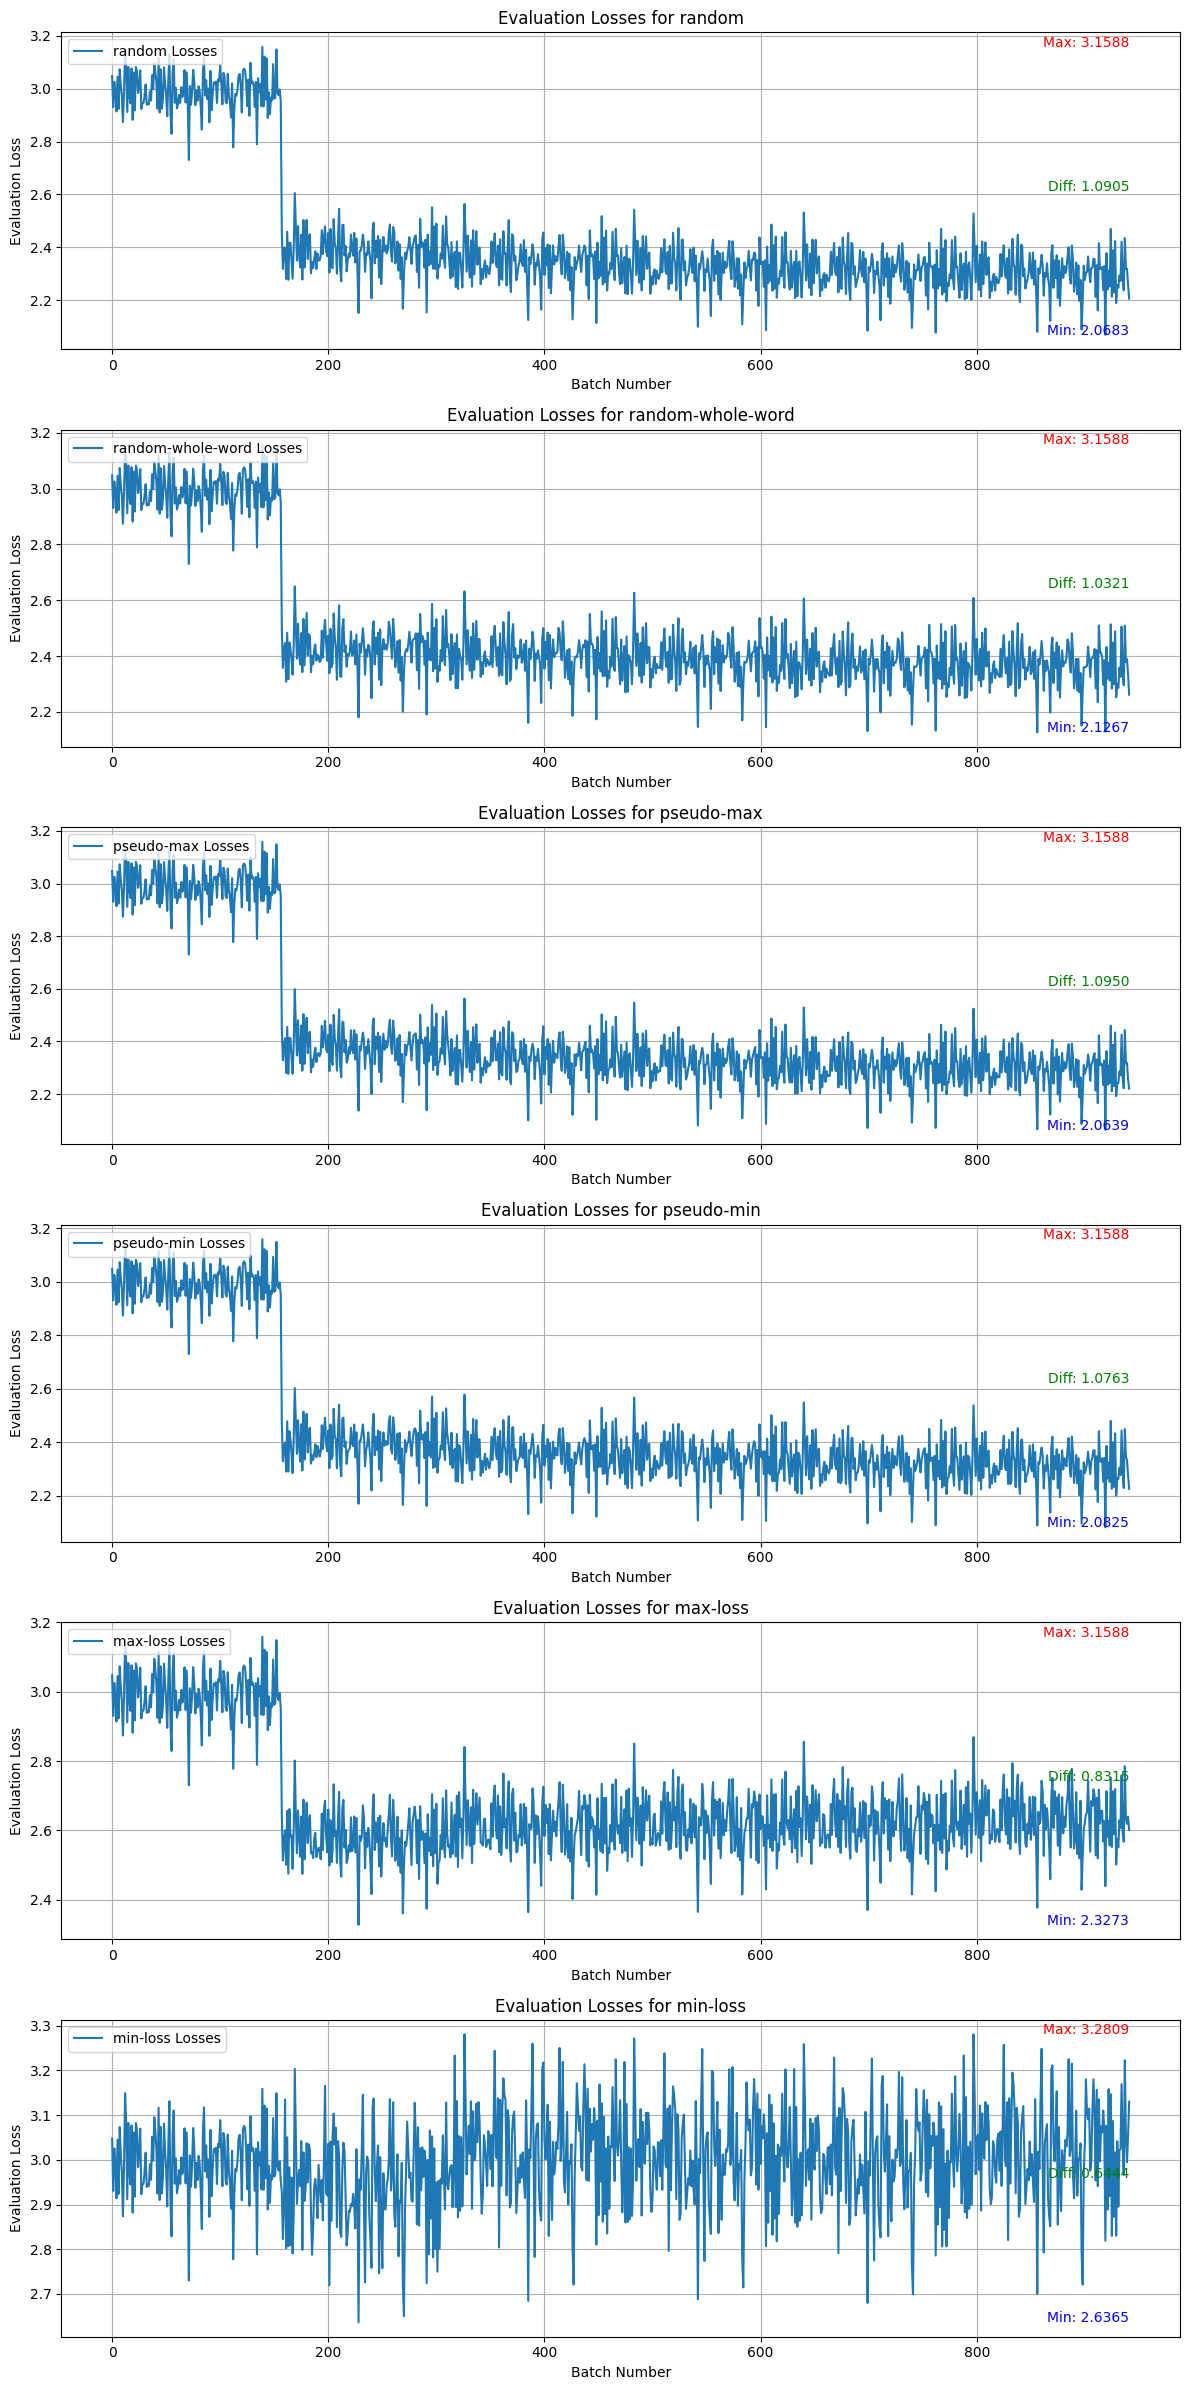

In [ ]:
import matplotlib.pyplot as plt

# Number of models (subplots)
num_models = len(losses_eval.keys())

fig, axes = plt.subplots(num_models, 1, figsize=(12, 4 * num_models))

if num_models == 1:
    axes = [axes]

for i, key in enumerate(losses_eval.keys()):
    losses = losses_eval[key]
    ax = axes[i]

    ax.plot(losses, label=f'{key} Losses')

    max_loss = max(losses)
    min_loss = min(losses)
    difference = max_loss - min_loss

    ax.text(len(losses) - 1, max_loss, f'Max: {max_loss:.4f}', color='red', fontsize=10, ha='right')
    ax.text(len(losses) - 1, min_loss, f'Min: {min_loss:.4f}', color='blue', fontsize=10, ha='right')
    ax.text(len(losses) - 1, (max_loss + min_loss) / 2, f'Diff: {difference:.4f}', color='green', fontsize=10, ha='right')

    ax.set_xlabel('Batch Number')
    ax.set_ylabel('Evaluation Loss')
    ax.set_title(f'Evaluation Losses for {key}')
    ax.legend(loc='upper left')
    ax.grid(True)

plt.tight_layout()

plt.show()


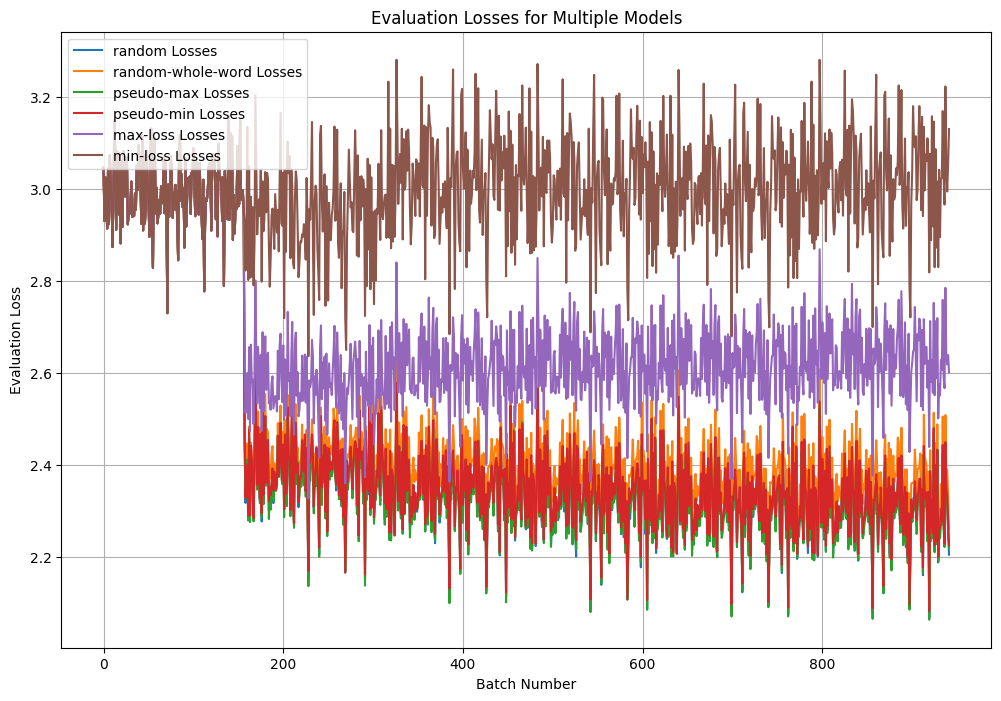

In [ ]:
import matplotlib.pyplot as plt


# Plotting
plt.figure(figsize=(12, 8))
for key in losses_eval.keys():
    losses = losses_eval[key]
    # Plot the losses for the current model
    plt.plot(losses, label=f'{key} Losses')

plt.xlabel('Batch Number')
plt.ylabel('Evaluation Loss')
plt.title('Evaluation Losses for Multiple Models')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()



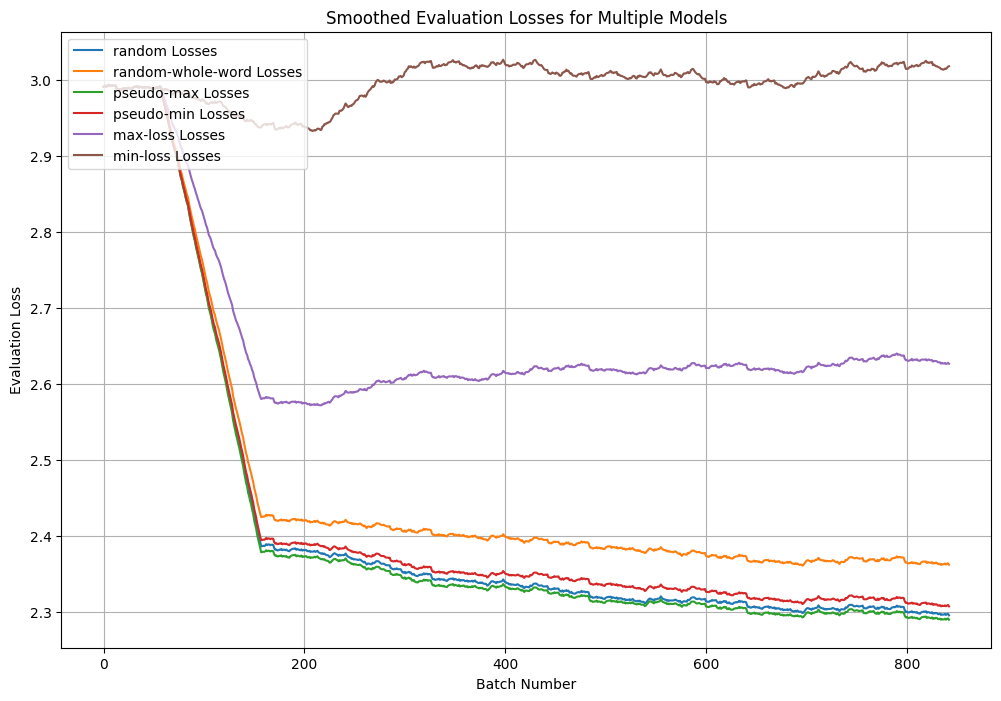

In [ ]:
def smooth(values, window_size=100):
    """Apply a simple moving average to smooth the values."""
    return np.convolve(values, np.ones(window_size)/window_size, mode='valid')

# Create a new dictionary for smoothed losses
smoothed_losses_eval = {}

# Apply smoothing and store in the new dictionary
for name, losses in losses_eval.items():
    smoothed_losses_eval[name] = smooth(losses)

# Plotting
plt.figure(figsize=(12, 8))
for key in smoothed_losses_eval.keys():
    losses = smoothed_losses_eval[key]
    # Plot the losses for the current model
    plt.plot(losses, label=f'{key} Losses')

plt.xlabel('Batch Number')
plt.ylabel('Evaluation Loss')
plt.title('Smoothed Evaluation Losses for Multiple Models')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

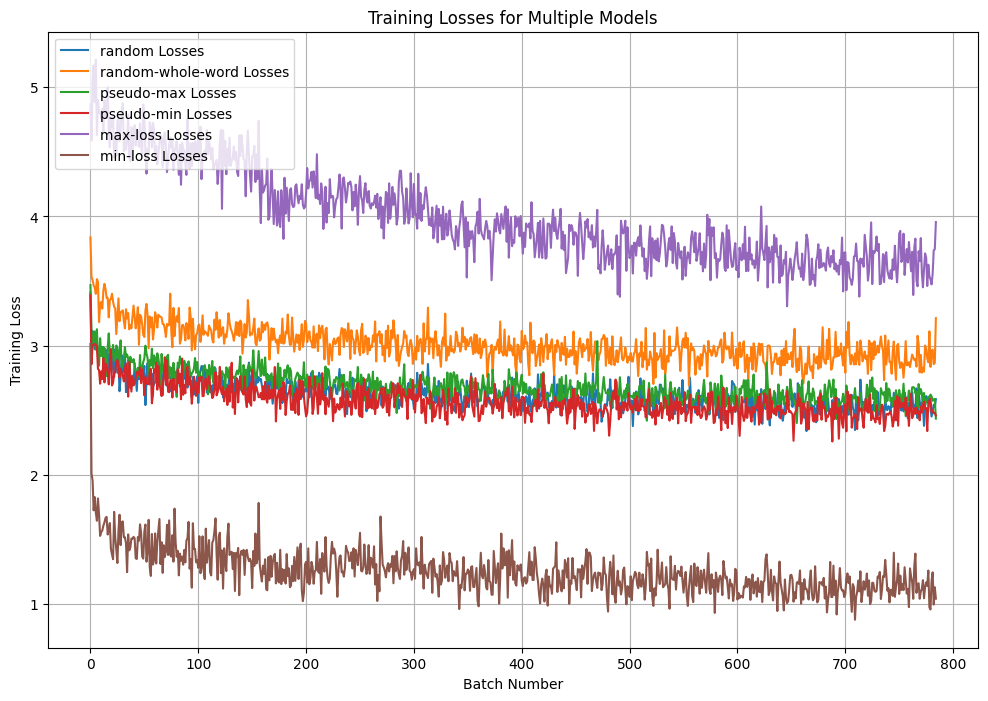

In [ ]:
import matplotlib.pyplot as plt


# Plotting
plt.figure(figsize=(12, 8))
for key in losses_train.keys():
    losses = losses_train[key]
    # Plot the losses for the current model
    plt.plot(losses, label=f'{key} Losses')

plt.xlabel('Batch Number')
plt.ylabel('Training Loss')
plt.title('Training Losses for Multiple Models')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

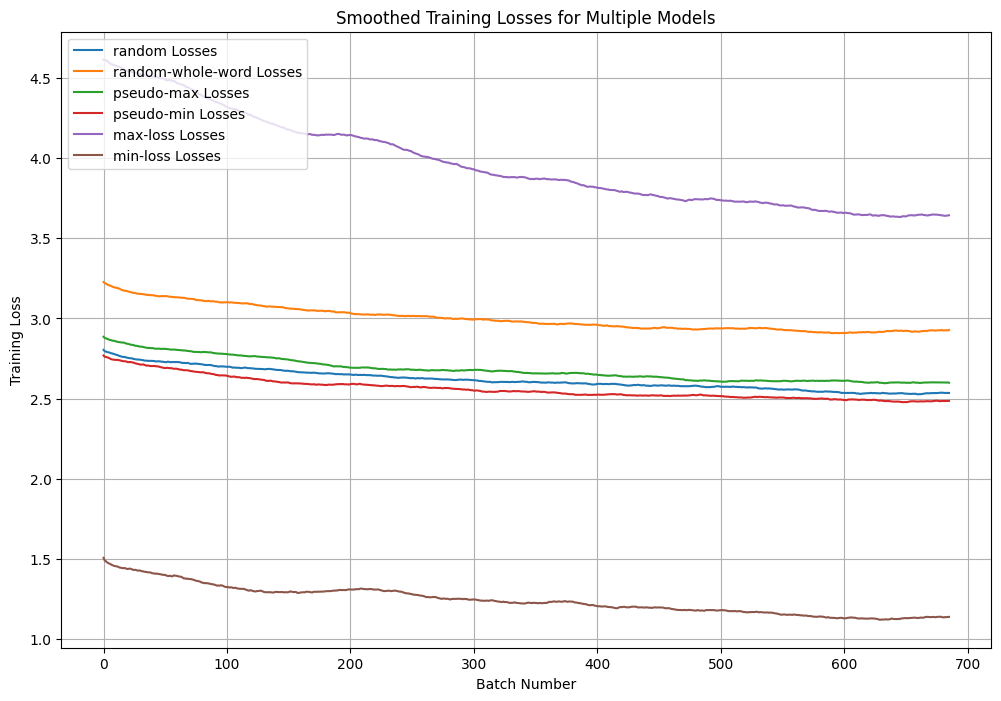

In [ ]:
def smooth(values, window_size=100):
    """Apply a simple moving average to smooth the values."""
    return np.convolve(values, np.ones(window_size)/window_size, mode='valid')

# Create a new dictionary for smoothed losses
smoothed_losses_train = {}

# Apply smoothing and store in the new dictionary
for name, losses in losses_train.items():
    smoothed_losses_train[name] = smooth(losses)

# Plotting
plt.figure(figsize=(12, 8))
for key in smoothed_losses_train.keys():
    losses = smoothed_losses_train[key]
    # Plot the losses for the current model
    plt.plot(losses, label=f'{key} Losses')

plt.xlabel('Batch Number')
plt.ylabel('Training Loss')
plt.title('Smoothed Training Losses for Multiple Models')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

<ipython-input-36-e55f49df0bd5>:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax.bar(models, values, color=plt.cm.get_cmap('tab10', len(models)).colors)
<ipython-input-36-e55f49df0bd5>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(models, rotation=45, ha='right')


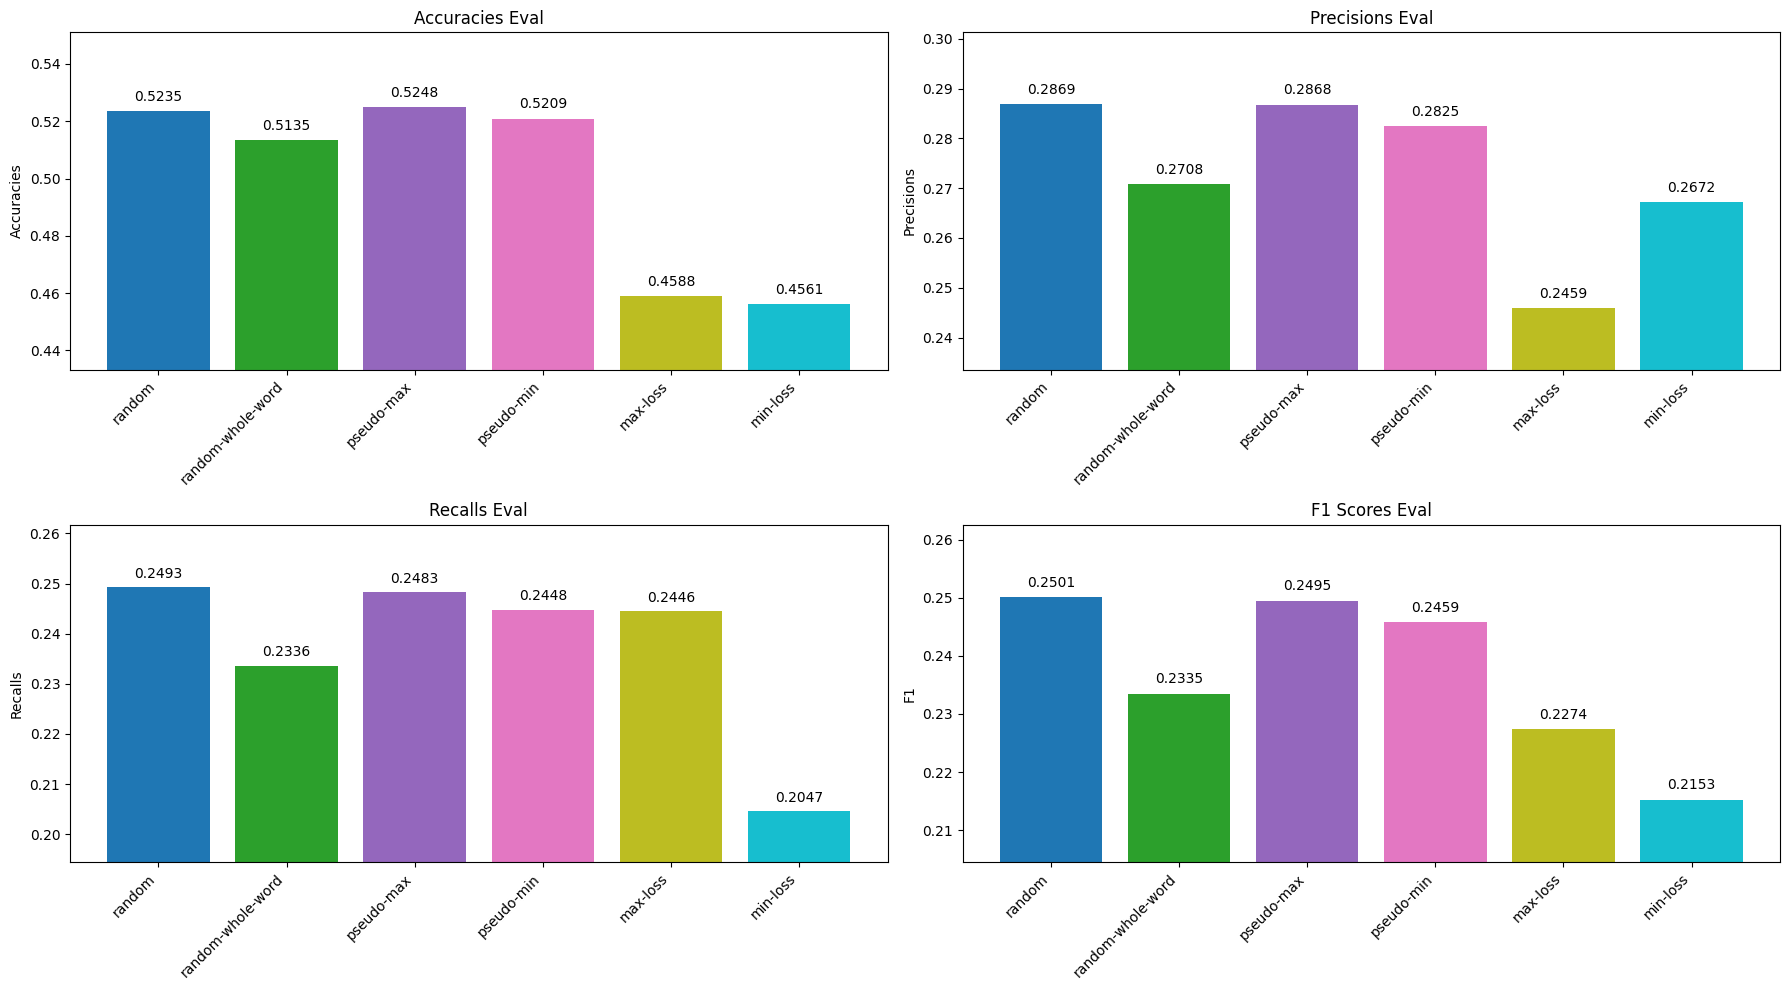

In [ ]:
# Extract the final values for each metric for each model
final_metrics = {
    "accuracies_eval": {model: acc[-1] for model, acc in results["accuracies_eval"].items()},
    "precisions_eval": {model: prec[-1] for model, prec in results["precisions_eval"].items()},
    "recalls_eval": {model: rec[-1] for model, rec in results["recalls_eval"].items()},
    "f1_scores_eval": {model: f1[-1] for model, f1 in results["f1_scores_eval"].items()},
}

# Plotting bar graphs for each metric
metrics = ["accuracies_eval", "precisions_eval", "recalls_eval", "f1_scores_eval"]
fig, axes = plt.subplots(2, 2, figsize=(18, 10))  # 2 rows, 2 columns

for i, metric in enumerate(metrics):
    ax = axes[i//2, i%2]  # Positioning subplot
    models = list(final_metrics[metric].keys())
    values = list(final_metrics[metric].values())

    ax.bar(models, values, color=plt.cm.get_cmap('tab10', len(models)).colors)
    ax.set_title(metric.replace('_', ' ').title())
    ax.set_ylabel(metric.split('_')[0].title())
    ax.set_xticklabels(models, rotation=45, ha='right')

    # Setting tighter Y-axis limits
    ax.set_ylim(min(values) * 0.95, max(values) * 1.05)

    # Adding value labels on top of bars
    for j, v in enumerate(values):
        ax.text(j, v + (max(values) * 0.005), f"{v:.4f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Whole Word Comparison

In [ ]:
from transformers import DataCollatorForLanguageModeling
data_collator = whole_word_random_collator(None, tokenizer, device)

downsampled_dataset = load_from_disk("downsampled_dataset")

def insert_mask(batch):
  features = [dict(zip(batch, t)) for t in zip(*batch.values())]
  masked_inputs = data_collator(features)
  return {"masked_" + k: v.cpu().numpy() for k, v in masked_inputs.items()}

eval_dataset = downsampled_dataset["test"].map(
    insert_mask,
    batched=True,
    remove_columns=downsampled_dataset["test"].column_names,
)

eval_dataset = eval_dataset.rename_columns(
  {
      "masked_input_ids": "input_ids",
      "masked_attention_mask": "attention_mask",
      "masked_labels": "labels",
  }
)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
losses_train = {}
losses_eval = {}
accuracies_eval = {}
precisions_eval = {}
recalls_eval = {}
f1_scores_eval = {}

collators = [whole_word_random_collator, psudo_min_loss_data_collator_ww, psudo_max_loss_data_collator_ww]
names = ["random-whole-word-ww-comparison", "pseudo-min-ww", "pseudo-max-ww"]
for collator, name in zip(collators, names):
    model = AutoModelForMaskedLM.from_pretrained(model_checkpoint).to(device)
    data_collator = collator(model, tokenizer, device)
    trainer = CustomTrainer(model, tokenizer, device, downsampled_dataset['train'], eval_dataset, data_collator)

    trainer.train()
    model.push_to_hub(name)

    # Store losses and metrics
    losses_train[name] = trainer.train_losses
    losses_eval[name] = trainer.eval_losses
    accuracies_eval[name] = trainer.accuracies
    precisions_eval[name] = trainer.precisions
    recalls_eval[name] = trainer.recalls
    f1_scores_eval[name] = trainer.f1_scores
    del model
    del trainer
    del data_collator
    torch.cuda.empty_cache()

  0%|          | 0/785 [00:00<?, ?it/s]

>>> Pre-Training: Perplexity: 41.5472, Accuracy: 0.3533, Precision: 0.1036, Recall: 0.1123, F1: 0.0916
>>> 0: Perplexity: 19.2523, Accuracy: 0.4609, Precision: 0.1667, Recall: 0.1157, F1: 0.1235
>>> 1: Perplexity: 18.2102, Accuracy: 0.4684, Precision: 0.1710, Recall: 0.1202, F1: 0.1282
>>> 2: Perplexity: 17.5982, Accuracy: 0.4739, Precision: 0.1766, Recall: 0.1217, F1: 0.1307
>>> 3: Perplexity: 17.2377, Accuracy: 0.4764, Precision: 0.1764, Recall: 0.1234, F1: 0.1319
>>> 4: Perplexity: 17.0881, Accuracy: 0.4775, Precision: 0.1759, Recall: 0.1250, F1: 0.1332


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

  0%|          | 0/785 [00:00<?, ?it/s]

>>> Pre-Training: Perplexity: 41.5472, Accuracy: 0.3533, Precision: 0.1036, Recall: 0.1123, F1: 0.0916
>>> 0: Perplexity: 19.4827, Accuracy: 0.4589, Precision: 0.1658, Recall: 0.1171, F1: 0.1247
>>> 1: Perplexity: 18.5811, Accuracy: 0.4662, Precision: 0.1676, Recall: 0.1196, F1: 0.1267
>>> 2: Perplexity: 17.9007, Accuracy: 0.4717, Precision: 0.1717, Recall: 0.1198, F1: 0.1281
>>> 3: Perplexity: 17.5301, Accuracy: 0.4744, Precision: 0.1732, Recall: 0.1203, F1: 0.1292
>>> 4: Perplexity: 17.3791, Accuracy: 0.4754, Precision: 0.1738, Recall: 0.1226, F1: 0.1307


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

  0%|          | 0/785 [00:00<?, ?it/s]

>>> Pre-Training: Perplexity: 41.5472, Accuracy: 0.3533, Precision: 0.1036, Recall: 0.1123, F1: 0.0916
>>> 0: Perplexity: 18.9823, Accuracy: 0.4632, Precision: 0.1741, Recall: 0.1143, F1: 0.1250
>>> 1: Perplexity: 17.9576, Accuracy: 0.4701, Precision: 0.1721, Recall: 0.1210, F1: 0.1287
>>> 2: Perplexity: 17.3685, Accuracy: 0.4752, Precision: 0.1761, Recall: 0.1238, F1: 0.1321
>>> 3: Perplexity: 17.0538, Accuracy: 0.4772, Precision: 0.1760, Recall: 0.1244, F1: 0.1326
>>> 4: Perplexity: 16.8951, Accuracy: 0.4786, Precision: 0.1774, Recall: 0.1268, F1: 0.1346


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
import json
from google.colab import files

# Combine all dictionaries into one for saving
results = {
    "losses_train": losses_train,
    "losses_eval": losses_eval,
    "accuracies_eval": accuracies_eval,
    "precisions_eval": precisions_eval,
    "recalls_eval": recalls_eval,
    "f1_scores_eval": f1_scores_eval
}

# Save the combined dictionary to a JSON file
results_file_path = "ww_models_metrics.json"
with open(results_file_path, 'w') as f:
    json.dump(results, f, indent=4)

# Download the file
files.download(results_file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

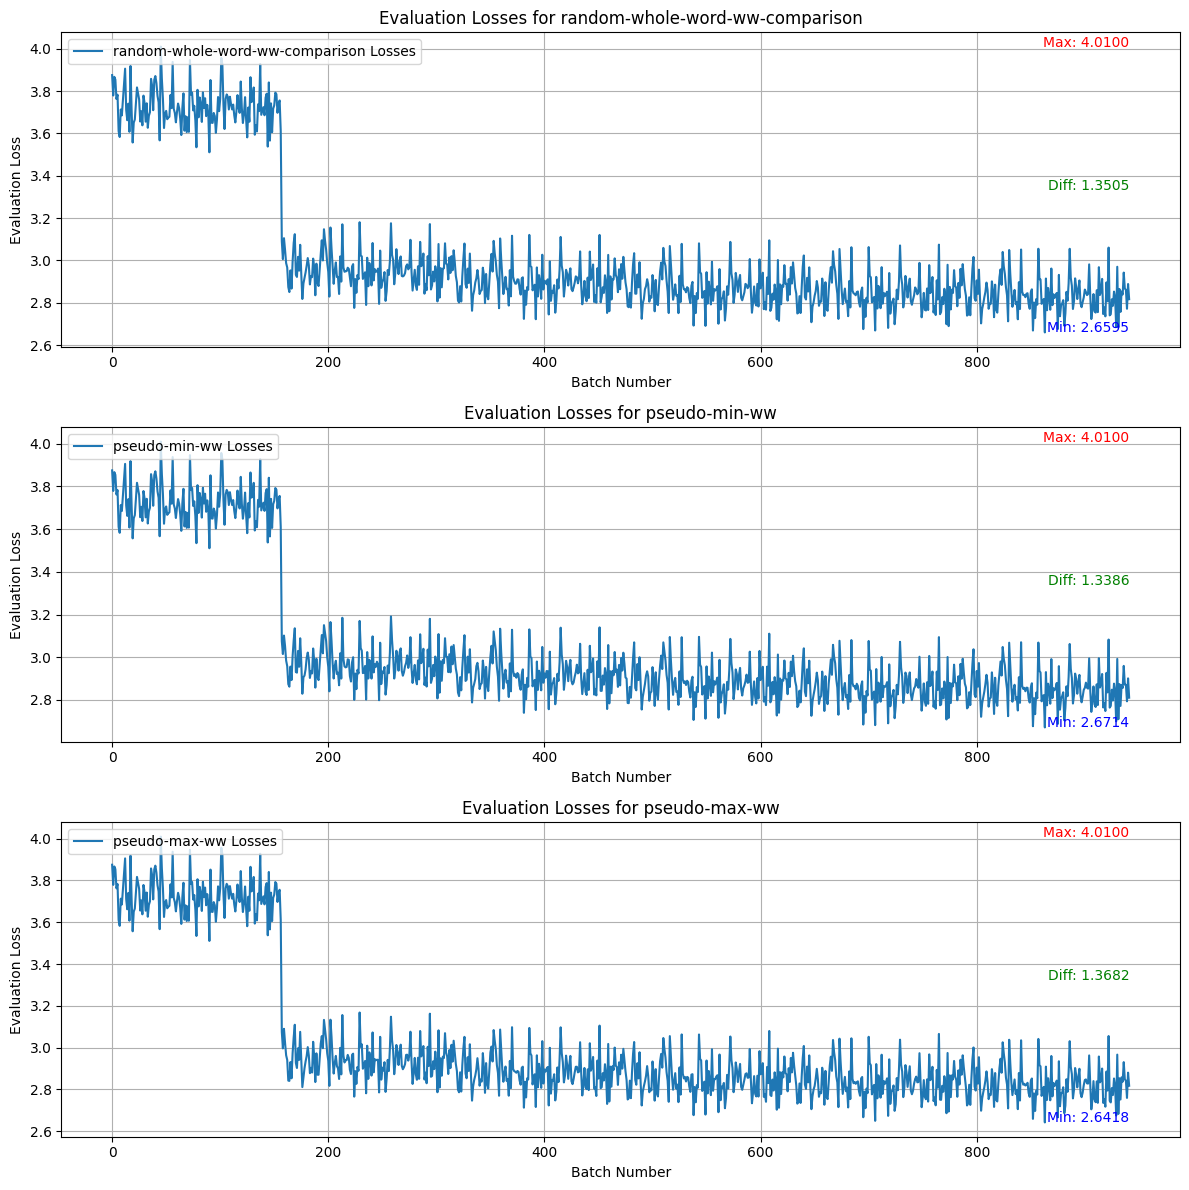

In [ ]:
import matplotlib.pyplot as plt

# Number of models (subplots)
num_models = len(losses_eval.keys())

fig, axes = plt.subplots(num_models, 1, figsize=(12, 4 * num_models))

if num_models == 1:
    axes = [axes]

for i, key in enumerate(losses_eval.keys()):
    losses = losses_eval[key]
    ax = axes[i]

    ax.plot(losses, label=f'{key} Losses')

    max_loss = max(losses)
    min_loss = min(losses)
    difference = max_loss - min_loss

    ax.text(len(losses) - 1, max_loss, f'Max: {max_loss:.4f}', color='red', fontsize=10, ha='right')
    ax.text(len(losses) - 1, min_loss, f'Min: {min_loss:.4f}', color='blue', fontsize=10, ha='right')
    ax.text(len(losses) - 1, (max_loss + min_loss) / 2, f'Diff: {difference:.4f}', color='green', fontsize=10, ha='right')

    ax.set_xlabel('Batch Number')
    ax.set_ylabel('Evaluation Loss')
    ax.set_title(f'Evaluation Losses for {key}')
    ax.legend(loc='upper left')
    ax.grid(True)

plt.tight_layout()

plt.show()

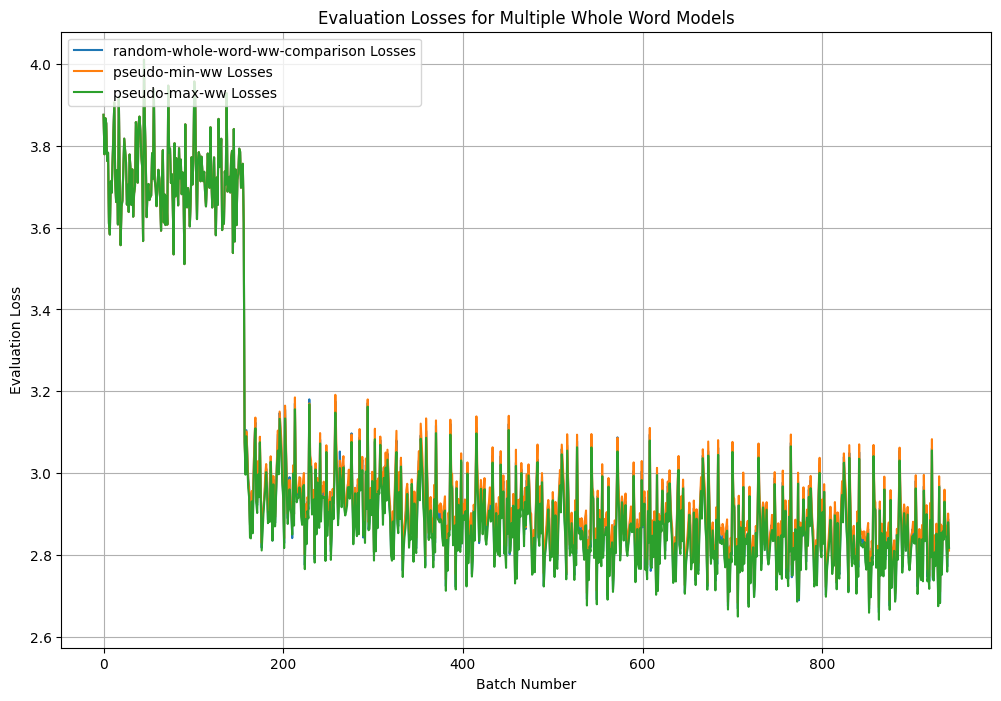

In [ ]:
import matplotlib.pyplot as plt


# Plotting
plt.figure(figsize=(12, 8))
for key in losses_eval.keys():
    losses = losses_eval[key]
    # Plot the losses for the current model
    plt.plot(losses, label=f'{key} Losses')

plt.xlabel('Batch Number')
plt.ylabel('Evaluation Loss')
plt.title('Evaluation Losses for Multiple Whole Word Models')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

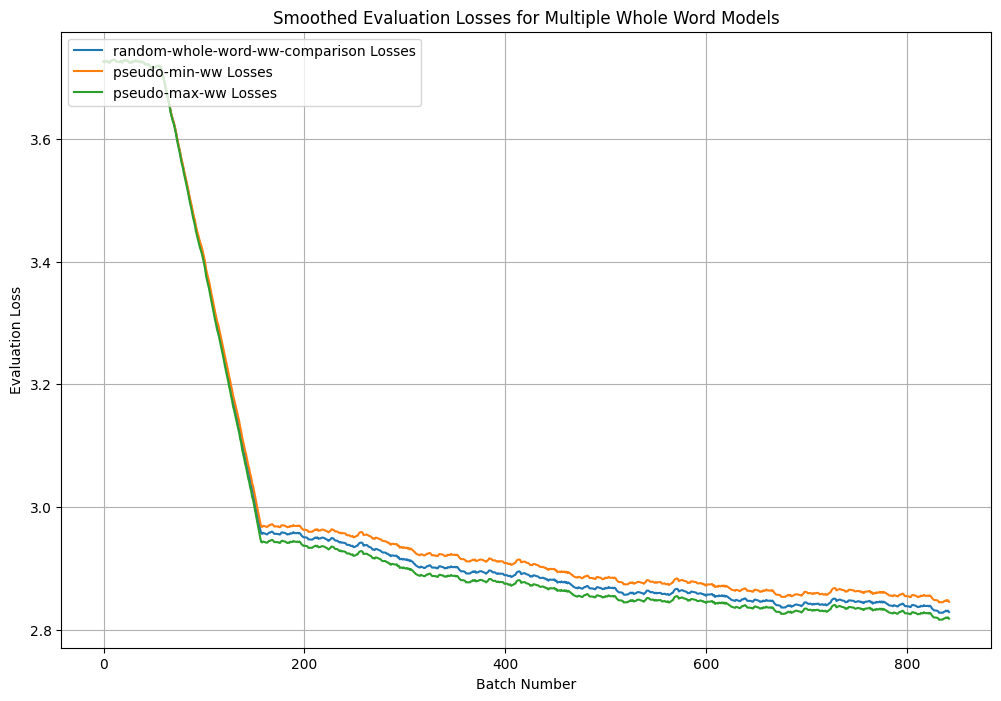

In [ ]:
def smooth(values, window_size=100):
    """Apply a simple moving average to smooth the values."""
    return np.convolve(values, np.ones(window_size)/window_size, mode='valid')

# Create a new dictionary for smoothed losses
smoothed_losses_eval = {}

# Apply smoothing and store in the new dictionary
for name, losses in losses_eval.items():
    smoothed_losses_eval[name] = smooth(losses)

# Plotting
plt.figure(figsize=(12, 8))
for key in smoothed_losses_eval.keys():
    losses = smoothed_losses_eval[key]
    # Plot the losses for the current model
    plt.plot(losses, label=f'{key} Losses')

plt.xlabel('Batch Number')
plt.ylabel('Evaluation Loss')
plt.title('Smoothed Evaluation Losses for Multiple Whole Word Models')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

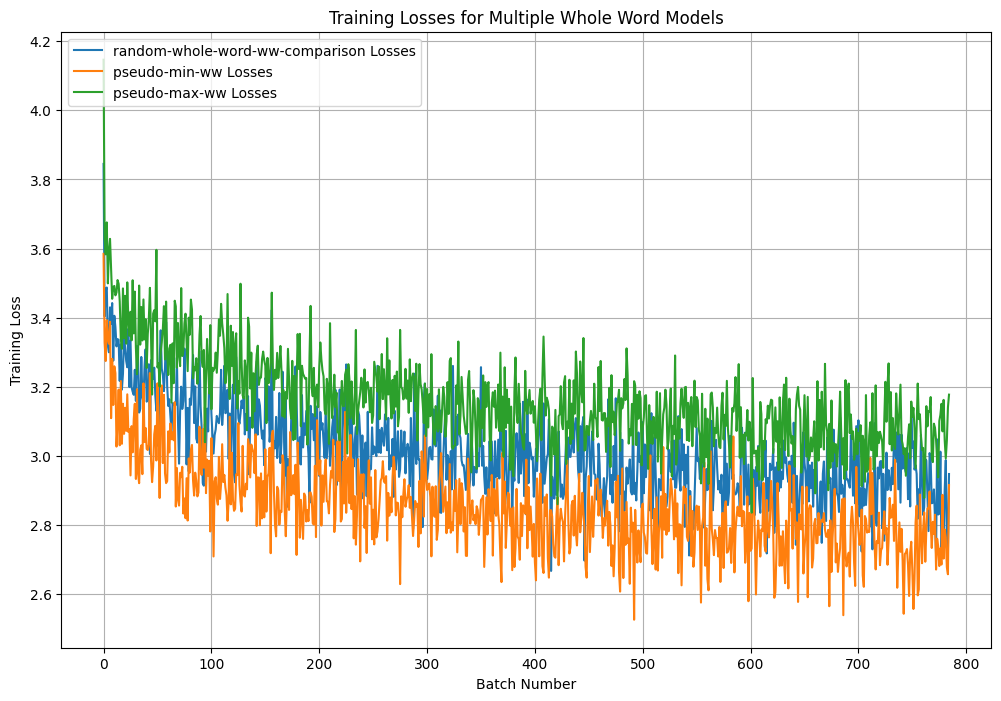

In [ ]:
import matplotlib.pyplot as plt


# Plotting
plt.figure(figsize=(12, 8))
for key in losses_train.keys():
    losses = losses_train[key]
    # Plot the losses for the current model
    plt.plot(losses, label=f'{key} Losses')

plt.xlabel('Batch Number')
plt.ylabel('Training Loss')
plt.title('Training Losses for Multiple Whole Word Models')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

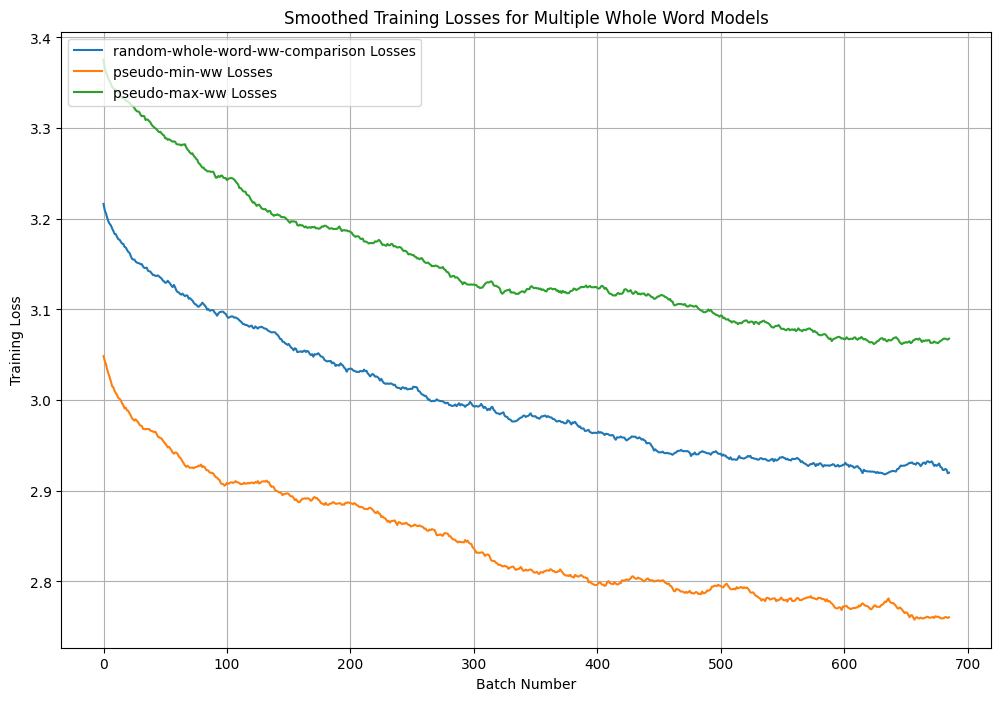

In [ ]:
def smooth(values, window_size=100):
    """Apply a simple moving average to smooth the values."""
    return np.convolve(values, np.ones(window_size)/window_size, mode='valid')

# Create a new dictionary for smoothed losses
smoothed_losses_train = {}

# Apply smoothing and store in the new dictionary
for name, losses in losses_train.items():
    smoothed_losses_train[name] = smooth(losses)

# Plotting
plt.figure(figsize=(12, 8))
for key in smoothed_losses_train.keys():
    losses = smoothed_losses_train[key]
    # Plot the losses for the current model
    plt.plot(losses, label=f'{key} Losses')

plt.xlabel('Batch Number')
plt.ylabel('Training Loss')
plt.title('Smoothed Training Losses for Multiple Whole Word Models')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

<ipython-input-22-0d05f0b12dfb>:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax.bar(models, values, color=plt.cm.get_cmap('tab10', len(models)).colors)
<ipython-input-22-0d05f0b12dfb>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(models, rotation=45, ha='right')


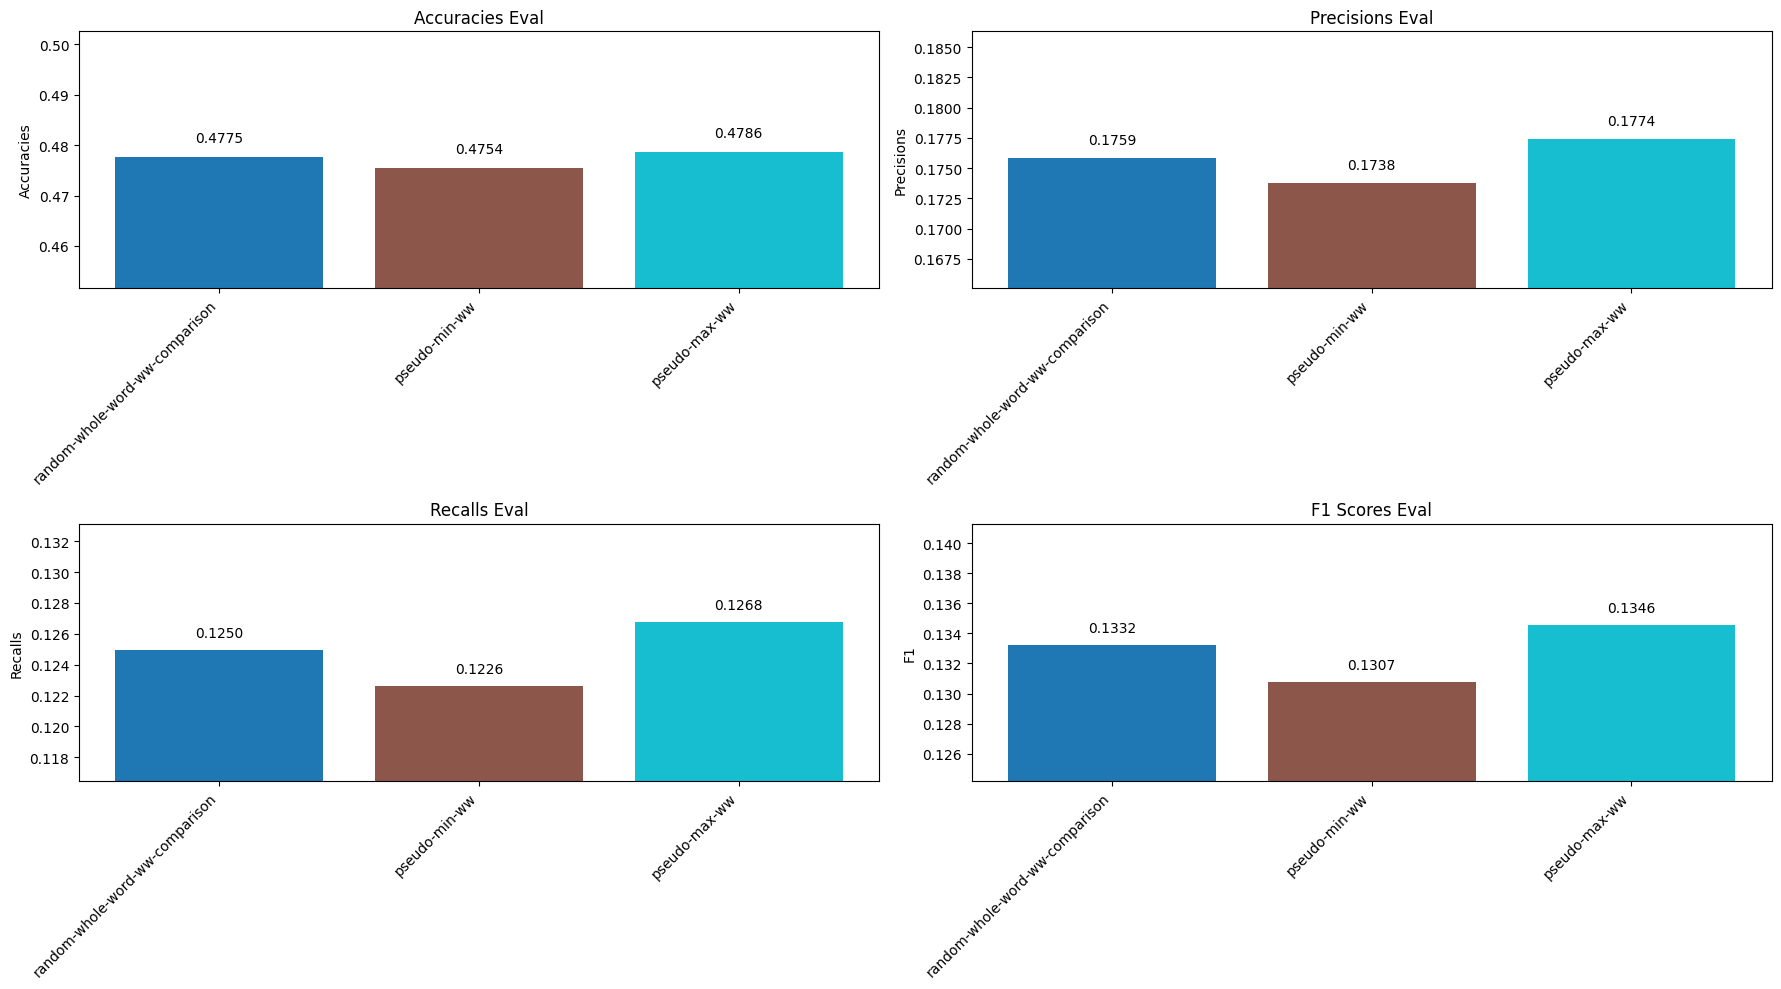

In [ ]:
# Extract the final values for each metric for each model
final_metrics = {
    "accuracies_eval": {model: acc[-1] for model, acc in results["accuracies_eval"].items()},
    "precisions_eval": {model: prec[-1] for model, prec in results["precisions_eval"].items()},
    "recalls_eval": {model: rec[-1] for model, rec in results["recalls_eval"].items()},
    "f1_scores_eval": {model: f1[-1] for model, f1 in results["f1_scores_eval"].items()},
}

# Plotting bar graphs for each metric
metrics = ["accuracies_eval", "precisions_eval", "recalls_eval", "f1_scores_eval"]
fig, axes = plt.subplots(2, 2, figsize=(18, 10))  # 2 rows, 2 columns

for i, metric in enumerate(metrics):
    ax = axes[i//2, i%2]  # Positioning subplot
    models = list(final_metrics[metric].keys())
    values = list(final_metrics[metric].values())

    ax.bar(models, values, color=plt.cm.get_cmap('tab10', len(models)).colors)
    ax.set_title(metric.replace('_', ' ').title())
    ax.set_ylabel(metric.split('_')[0].title())
    ax.set_xticklabels(models, rotation=45, ha='right')

    # Setting tighter Y-axis limits
    ax.set_ylim(min(values) * 0.95, max(values) * 1.05)

    # Adding value labels on top of bars
    for j, v in enumerate(values):
        ax.text(j, v + (max(values) * 0.005), f"{v:.4f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Transfer tasks

# setup

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
import evaluate
import numpy as np
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer


imdb = load_dataset("imdb")
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)
tokenized_imdb = imdb.map(preprocess_function, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)



Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


num params: 66955010
num trainable params: 592130


# Train

In [ ]:
names = ["random",
"random-whole-word",
"pseudo-max",
"pseudo-min",
"min-loss",
"max-loss"]
for name in names:
    model = AutoModelForSequenceClassification.from_pretrained(
        f"gcnlpruni/{name}", num_labels=2, id2label=id2label, label2id=label2id
    )

    for name, param in model.named_parameters():
        if name.startswith("distilbert"):
            param.requires_grad = False

    training_args = TrainingArguments(
        output_dir="choose output dir",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=2,
        weight_decay=0.01,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        push_to_hub=True,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_imdb["train"],
        eval_dataset=tokenized_imdb["test"],
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    trainer.train()
